In [1]:
# packages for rl environment and rendering
import gymnasium as gym
import mujoco
import glfw

In [2]:
# necessary packages for model
import os
import json
import pickle
import time
from tqdm import tqdm
import math
import numpy as np
import random
import torch
import einops
from einops.layers.torch import Rearrange
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [85]:
# data: sampled trajectories, each trajectory is sequence of vectors formed by concatenating state and action
# values: value associated with each trajectory

**Model Architecute and Details Illustration**

In [3]:
# Define Mish activation function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Sinusoidal Position Embeddings
# Input Shape: t of shape [batch_size]
# Output Shape: [batch_size, dim]
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# Downsampling layer
class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

# Upsampling layer
class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

# Convolutional block
# Input Shape: x of shape [batch_size, in_channels, seq_len]
# Output Shape: [batch_size, out_channels, seq_len]
class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            Rearrange('batch channels horizon -> batch channels 1 horizon'),
            nn.GroupNorm(n_groups, out_channels),
            Rearrange('batch channels 1 horizon -> batch channels horizon'),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


#-----------------------------------------------------------------------------#
#--------------------------------- attention ---------------------------------#
#-----------------------------------------------------------------------------#

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
        
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1))

    def forward(self, x):
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b
        
# Pre-normalization wrapper
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Linear Attention (optional, can be simplified)
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: einops.rearrange(t, 'b (h c) d -> b h c d', h=self.heads), qkv)
        q = q * self.scale

        k = k.softmax(dim = -1)
        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = einops.rearrange(out, 'b h c d -> b (h c) d')
        return self.to_out(out)


#-----------------------------------------------------------------------------#
#---------------------------- diffusion model---------------------------------#
#-----------------------------------------------------------------------------#

# Residual Temporal Block
# Input Shapes: x: [batch_size, inp_channels, seq_len], t: [batch_size, embed_dim] (time embeddings)
# Output Shape: [batch_size, out_channels, seq_len]
class ResidualTemporalBlock(nn.Module):
    def __init__(self, inp_channels, out_channels, embed_dim, horizon, kernel_size=5):
        super().__init__()
        self.blocks = nn.ModuleList([
            Conv1dBlock(inp_channels, out_channels, kernel_size),
            Conv1dBlock(out_channels, out_channels, kernel_size),
        ])

        self.time_mlp = nn.Sequential(
            Mish(),
            nn.Linear(embed_dim, out_channels),
            Rearrange('batch c -> batch c 1'),
        )

        self.residual_conv = nn.Conv1d(inp_channels, out_channels, 1) \
            if inp_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        # x: (batch_size, channels, seq_len)
        # t: (batch_size, embed_dim)
        out = self.blocks[0](x) + self.time_mlp(t) # [batch_size, out_channels, seq_len]
        out = self.blocks[1](out)
        return out + self.residual_conv(x)

# Temporal U-Net
class TemporalUnet(nn.Module):
    def __init__(self, horizon, transition_dim, cond_dim, dim=32, dim_mults=(1, 2, 4, 8), attention=False):
        super().__init__()

        # dims: A list of channel dimensions at each level, computed as [transition_dim] + [dim * m for m in dim_mults]
        # in_out: A list of tuples pairing input and output dimensions at each level, e.g., [(transition_dim, dim), (dim, dim * 2), ...]
        dims = [transition_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # Time embedding, map scalar time steps to embeddings.
        # [batch_size] → [batch_size, dim]
        time_dim = dim
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim),
        )

        # Downsampling Blocks (self.downs)
        # Each block consists of two ResidualTemporalBlocks, optional attention, and a Downsample1d.
        # Reduces the sequence length and increases the channel dimension.
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        current_horizon = horizon

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                ResidualTemporalBlock(dim_in, dim_out, embed_dim=time_dim, horizon=current_horizon),
                ResidualTemporalBlock(dim_out, dim_out, embed_dim=time_dim, horizon=current_horizon),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))) if attention else nn.Identity(),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))
            if not is_last:
                current_horizon = current_horizon // 2

        # Middle Blocks (self.mid_block1, self.mid_attn, self.mid_block2):
        # Process the lowest-resolution representation
        mid_dim = dims[-1]
        self.mid_block1 = ResidualTemporalBlock(mid_dim, mid_dim, embed_dim=time_dim, horizon=current_horizon)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim))) if attention else nn.Identity()
        self.mid_block2 = ResidualTemporalBlock(mid_dim, mid_dim, embed_dim=time_dim, horizon=current_horizon)

        # Upsampling Blocks (self.ups)
        # Mirror the downsampling path, using Upsample1d to increase sequence length and decrease channel dimensions.
        # Skip connections concatenate features from the downsampling path.
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(nn.ModuleList([
                ResidualTemporalBlock(dim_out * 2, dim_in, embed_dim=time_dim, horizon=current_horizon),
                ResidualTemporalBlock(dim_in, dim_in, embed_dim=time_dim, horizon=current_horizon),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))) if attention else nn.Identity(),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))
            if not is_last:
                current_horizon = current_horizon * 2

        # Final Convolution (self.final_conv):
        # Maps back to the original transition_dim.
        self.final_conv = nn.Sequential(
            Conv1dBlock(dim, dim, kernel_size=5),
            nn.Conv1d(dim, transition_dim, 1),
        )

    def forward(self, x, cond, time):
        # x: (batch_size, horizon, transition_dim)
        x = einops.rearrange(x, 'b h t -> b t h')
        t = self.time_mlp(time)
        h = []

        for resnet1, resnet2, attn, downsample in self.downs:
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for resnet1, resnet2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = attn(x)
            x = upsample(x)

        x = self.final_conv(x)
        x = einops.rearrange(x, 'b t h -> b h t')
        return x


#-----------------------------------------------------------------------------#
#-------------------------------- value model---------------------------------#
#-----------------------------------------------------------------------------#

# Value Function
class ValueFunction(nn.Module):
    def __init__(self, horizon, transition_dim, cond_dim, dim=32, dim_mults=(1, 2, 4, 8), out_dim=1):
        super().__init__()

        dims = [transition_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        time_dim = dim
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim),
        )

        self.blocks = nn.ModuleList([])
        num_resolutions = len(in_out)
        current_horizon = horizon

        for ind, (dim_in, dim_out) in enumerate(in_out):
            self.blocks.append(nn.ModuleList([
                ResidualTemporalBlock(dim_in, dim_out, embed_dim=time_dim, horizon=current_horizon),
                ResidualTemporalBlock(dim_out, dim_out, embed_dim=time_dim, horizon=current_horizon),
                Downsample1d(dim_out)
            ]))
            current_horizon = max(current_horizon // 2, 1)

        mid_dim = dims[-1]
        mid_dim_2 = mid_dim // 2
        mid_dim_3 = mid_dim // 4

        self.mid_block1 = ResidualTemporalBlock(mid_dim, mid_dim_2, embed_dim=time_dim, horizon=current_horizon)
        self.mid_down1 = Downsample1d(mid_dim_2)
        current_horizon = max(current_horizon // 2, 1)

        self.mid_block2 = ResidualTemporalBlock(mid_dim_2, mid_dim_3, embed_dim=time_dim, horizon=current_horizon)
        self.mid_down2 = Downsample1d(mid_dim_3)
        current_horizon = max(current_horizon // 2, 1)

        fc_dim = mid_dim_3 * current_horizon

        self.final_block = nn.Sequential(
            nn.Linear(fc_dim + time_dim, fc_dim // 2),
            Mish(),
            nn.Linear(fc_dim // 2, out_dim),
        )

    def forward(self, x, cond, time):
        # x: (batch_size, horizon, transition_dim)
        x = einops.rearrange(x, 'b h t -> b t h')
        t = self.time_mlp(time)
        
        # Check the shape of x
        batch_size = x.size(0)  # Get the batch size from x
        
        # Adjust dimensions of t to match x
        if t.size(0) != batch_size:
            t = t.expand(batch_size, -1)  # Expand t to have the same batch size as x

        for resnet1, resnet2, downsample in self.blocks:
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_down1(x)

        x = self.mid_block2(x, t)
        x = self.mid_down2(x)

        x = x.view(len(x), -1)
        out = self.final_block(torch.cat([x, t], dim=-1))

        return out


<details>
<summary><strong>Model Overview</strong></summary>

## Model Overview

1. **Rearrange Input**:  
   The input tensor `x` is rearranged from shape `[batch_size, horizon, transition_dim]` to `[batch_size, transition_dim, horizon]` to prepare for convolution operations.
   
2. **Compute Time Embedding**:  
   The time tensor `t` is passed through `self.time_mlp`, transforming it into a tensor of shape `[batch_size, time_dim]`.

3. **Downsampling Path**:
   - Iteratively apply residual blocks, attention mechanisms (if used), and downsampling layers.
   - At each level of the network, store the output in the list `h` for use in skip connections during the upsampling path.

4. **Middle Blocks**:  
   - Apply `self.mid_block1` for processing in the middle of the network.
   - Apply `self.mid_attn` (optional attention layer).
   - Apply `self.mid_block2` for further processing.

5. **Upsampling Path**:
   - At each level of the upsampling path, concatenate the corresponding skip connection from `h`.
   - Apply residual blocks, attention mechanisms (if used), and upsampling layers.

6. **Final Convolution**:  
   Apply `self.final_conv` to map the tensor back to the shape `[batch_size, transition_dim, horizon]`.

7. **Rearrange Output**:  
   Rearrange the tensor back to the original shape `[batch_size, horizon, transition_dim]` for the final output.


</details>

<details>
<summary><strong>Diffusion Model Details</strong></summary>
    
## TemporalUnet Forward Pass with Input/Output Shapes:

### Time Embedding (`time_mlp`):
- **Input Shape**: `[batch_size]` (time tensor)
- **Output Shape**: `[batch_size, time_dim]` (after the sinusoidal embedding and linear layers)
- **Process**: Applies a sinusoidal positional embedding followed by two linear layers with Mish activation.

### Downsampling Path:

1. **ResidualTemporalBlock #1 (first block)**:
   - **Input Shape**: `[batch_size, 23, horizon]` (initial input)
   - **Output Shape**: `[batch_size, 32, horizon]`

2. **ResidualTemporalBlock #2**:
   - **Input Shape**: `[batch_size, 32, horizon]`
   - **Output Shape**: `[batch_size, 32, horizon]`

3. **Downsample1d**:
   - **Input Shape**: `[batch_size, 32, horizon]`
   - **Output Shape**: `[batch_size, 32, horizon // 2]` (reduces sequence length)

---

4. **ResidualTemporalBlock #3**:
   - **Input Shape**: `[batch_size, 32, horizon // 2]`
   - **Output Shape**: `[batch_size, 64, horizon // 2]`

5. **ResidualTemporalBlock #4**:
   - **Input Shape**: `[batch_size, 64, horizon // 2]`
   - **Output Shape**: `[batch_size, 64, horizon // 2]`

6. **Downsample1d**:
   - **Input Shape**: `[batch_size, 64, horizon // 2]`
   - **Output Shape**: `[batch_size, 64, horizon // 4]`

---

7. **ResidualTemporalBlock #5**:
   - **Input Shape**: `[batch_size, 64, horizon // 4]`
   - **Output Shape**: `[batch_size, 128, horizon // 4]`

8. **ResidualTemporalBlock #6**:
   - **Input Shape**: `[batch_size, 128, horizon // 4]`
   - **Output Shape**: `[batch_size, 128, horizon // 4]`

9. **Downsample1d**:
   - **Input Shape**: `[batch_size, 128, horizon // 4]`
   - **Output Shape**: `[batch_size, 128, horizon // 8]`

---

10. **ResidualTemporalBlock #7**:
    - **Input Shape**: `[batch_size, 128, horizon // 8]`
    - **Output Shape**: `[batch_size, 256, horizon // 8]`

11. **ResidualTemporalBlock #8**:
    - **Input Shape**: `[batch_size, 256, horizon // 8]`
    - **Output Shape**: `[batch_size, 256, horizon // 8]`

12. **Downsample1d**:
    - **Input Shape**: `[batch_size, 256, horizon // 8]`
    - **Output Shape**: `[batch_size, 256, horizon // 16]`

---

### Middle Blocks:

1. **ResidualTemporalBlock**:
   - **Input Shape**: `[batch_size, 256, horizon // 16]`
   - **Output Shape**: `[batch_size, 256, horizon // 16]`

2. **Middle Attention Block** (if applied):
   - **Input Shape**: `[batch_size, 256, horizon // 16]`
   - **Output Shape**: `[batch_size, 256, horizon // 16]`

3. **ResidualTemporalBlock**:
   - **Input Shape**: `[batch_size, 256, horizon // 16]`
   - **Output Shape**: `[batch_size, 256, horizon // 16]`

---

### Upsampling Path:

1. **ResidualTemporalBlock #1 (first upsampling block)**:
   - **Input Shape**: `[batch_size, 512, horizon // 16]` (concatenated with skip connection from downsampling)
   - **Output Shape**: `[batch_size, 128, horizon // 16]`

2. **Upsample1d**:
   - **Input Shape**: `[batch_size, 128, horizon // 16]`
   - **Output Shape**: `[batch_size, 128, horizon // 8]`

---

3. **ResidualTemporalBlock #2**:
   - **Input Shape**: `[batch_size, 256, horizon // 8]` (concatenated with skip connection from downsampling)
   - **Output Shape**: `[batch_size, 64, horizon // 8]`

4. **Upsample1d**:
   - **Input Shape**: `[batch_size, 64, horizon // 8]`
   - **Output Shape**: `[batch_size, 64, horizon // 4]`

---

5. **ResidualTemporalBlock #3**:
   - **Input Shape**: `[batch_size, 128, horizon // 4]` (concatenated with skip connection from downsampling)
   - **Output Shape**: `[batch_size, 32, horizon // 4]`

6. **Upsample1d**:
   - **Input Shape**: `[batch_size, 32, horizon // 4]`
   - **Output Shape**: `[batch_size, 32, horizon // 2]`

---

7. **ResidualTemporalBlock #4**:
   - **Input Shape**: `[batch_size, 64, horizon // 2]` (concatenated with skip connection from downsampling)
   - **Output Shape**: `[batch_size, 32, horizon // 2]`

8. **Upsample1d**:
   - **Input Shape**: `[batch_size, 32, horizon // 2]`
   - **Output Shape**: `[batch_size, 32, horizon]`

---

### Final Convolution (`final_conv`):

- **Input Shape**: `[batch_size, 32, horizon]`
- **Output Shape**: `[batch_size, 23, horizon]` (matching the original `transition_dim`)

---

## Summary of Important Shapes:

- **Input Shape**: `[batch_size, 23, horizon]` (initial input to the U-Net).
- **Output Shape**: `[batch_size, 23, horizon]` (final output after the U-Net, matching the input shape).
- For each block, downsampling halves the sequence length (horizon), while upsampling restores it.
- The feature dimensions start from `23` (input transition dimension) and go through `32`, `64`, `128`, `256` as the network deepens, then reverse during the upsampling stage.

</details>

<details>
<summary><strong>Value Function Details</strong></summary>
    
## ValueFunction Forward Pass with Input/Output Shapes:

### Time Embedding (`time_mlp`):
- **Input Shape**: `[batch_size]` (time tensor)
- **Output Shape**: `[batch_size, time_dim]` (after the sinusoidal embedding and linear layers)
- **Process**: Applies a sinusoidal positional embedding followed by two linear layers with Mish activation.

### Blocks:

#### Block #1:
1. **ResidualTemporalBlock #1**:
   - **Input Shape**: `[batch_size, 23, horizon]` (initial input)
   - **Output Shape**: `[batch_size, 32, horizon]`
   
2. **ResidualTemporalBlock #2**:
   - **Input Shape**: `[batch_size, 32, horizon]`
   - **Output Shape**: `[batch_size, 32, horizon]`

3. **Downsample1d**:
   - **Input Shape**: `[batch_size, 32, horizon]`
   - **Output Shape**: `[batch_size, 32, horizon // 2]`

---

#### Block #2:
1. **ResidualTemporalBlock #3**:
   - **Input Shape**: `[batch_size, 32, horizon // 2]`
   - **Output Shape**: `[batch_size, 64, horizon // 2]`

2. **ResidualTemporalBlock #4**:
   - **Input Shape**: `[batch_size, 64, horizon // 2]`
   - **Output Shape**: `[batch_size, 64, horizon // 2]`

3. **Downsample1d**:
   - **Input Shape**: `[batch_size, 64, horizon // 2]`
   - **Output Shape**: `[batch_size, 64, horizon // 4]`

---

#### Block #3:
1. **ResidualTemporalBlock #5**:
   - **Input Shape**: `[batch_size, 64, horizon // 4]`
   - **Output Shape**: `[batch_size, 128, horizon // 4]`

2. **ResidualTemporalBlock #6**:
   - **Input Shape**: `[batch_size, 128, horizon // 4]`
   - **Output Shape**: `[batch_size, 128, horizon // 4]`

3. **Downsample1d**:
   - **Input Shape**: `[batch_size, 128, horizon // 4]`
   - **Output Shape**: `[batch_size, 128, horizon // 8]`

---

#### Block #4:
1. **ResidualTemporalBlock #7**:
   - **Input Shape**: `[batch_size, 128, horizon // 8]`
   - **Output Shape**: `[batch_size, 256, horizon // 8]`

2. **ResidualTemporalBlock #8**:
   - **Input Shape**: `[batch_size, 256, horizon // 8]`
   - **Output Shape**: `[batch_size, 256, horizon // 8]`

3. **Downsample1d**:
   - **Input Shape**: `[batch_size, 256, horizon // 8]`
   - **Output Shape**: `[batch_size, 256, horizon // 16]`

---

### Middle Blocks:

1. **ResidualTemporalBlock**:
   - **Input Shape**: `[batch_size, 256, horizon // 16]`
   - **Output Shape**: `[batch_size, 128, horizon // 16]`

2. **Downsample1d**:
   - **Input Shape**: `[batch_size, 128, horizon // 16]`
   - **Output Shape**: `[batch_size, 128, horizon // 32]`

---

### Additional Blocks:

1. **ResidualTemporalBlock**:
   - **Input Shape**: `[batch_size, 128, horizon // 32]`
   - **Output Shape**: `[batch_size, 64, horizon // 32]`

2. **Downsample1d**:
   - **Input Shape**: `[batch_size, 64, horizon // 32]`
   - **Output Shape**: `[batch_size, 64, horizon // 64]`

---

### Final Block:

1. **Final Linear Block**:
   - **Input Shape**: `[batch_size, 96]` (concatenation of the flattened middle blocks and time embedding)
   - **Output Shape**: `[batch_size, 32]`

2. **Final Linear Output**:
   - **Input Shape**: `[batch_size, 32]`
   - **Output Shape**: `[batch_size, 1]` (final output value)

---

## Summary of Important Shapes:
- **Input Shape**: `[batch_size, 23, horizon]` (initial input to the Value function).
- **Output Shape**: `[batch_size, 1]` (final scalar value output).
- Throughout the blocks, downsampling reduces the sequence length (horizon) by half at each stage, and the feature dimensions increase from `23` to `256`. The middle block further processes and downscales the sequence length to provide a final value estimate.

</details>

**Load Trajectory Dataset**

In [7]:
class TrajectoryDataset(Dataset):
    def __init__(self, dataset, window_size=10, gamma=0.99):
        super(TrajectoryDataset, self).__init__()
        self.data = []
        self.window_size = window_size
        self.gamma = gamma

        # Collect all trajectory for calculating mean and std
        trajectories = []

        # Iterate through the dataset to collect state and action trajectories
        for traj in dataset:
            observations = np.array(traj['observations'])  # Shape (num_steps, 17)
            actions = np.array(traj['actions'])  # Shape (num_steps, 6)
            rewards = np.array(traj['rewards'])
            terminals = np.array(traj['terminals']) if 'terminals' in traj else None

            # Combine observations and actions for the purpose of normalization
            trajectories.append(np.concatenate((observations, actions), axis=-1))


        # Concatenate all states across trajectories and compute mean and std
        trajectories = np.concatenate(trajectories, axis=0)  # Shape (total_steps, state_dim + action_dim)
        self.mean = np.mean(trajectories, axis=0)  # Shape (state_dim + action_dim,)
        self.std = np.std(trajectories, axis=0)  # Shape (state_dim + action_dim,)

        # Now re-process the dataset to normalize the states
        for traj in dataset:
            observations = np.array(traj['observations'])  # Shape (num_steps, 17)
            actions = np.array(traj['actions'])  # Shape (num_steps, 6)
            rewards = np.array(traj['rewards'])

            # Combine normalized observations and actions
            # Normalize trajectory, only normalize state part, action is already within -1 and 1
            observations = (observations - self.mean[:len(observations[1])]) / self.std[:len(observations[1])]
            trajectory = np.concatenate((observations, actions), axis=-1)
            num_steps = len(rewards)

            # Break trajectory into windows
            for start in range(0, num_steps, window_size):
                end = min(start + window_size, num_steps)

                # Only consider full windows
                if end - start < window_size:
                    continue

                partial_trajectory = trajectory[start:end]

                # Calculate discounted cumulative reward for this window
                cumulative_reward = 0
                window_value = 0
                for t in reversed(range(start, end)):
                    cumulative_reward = rewards[t] + gamma * cumulative_reward
                    window_value = cumulative_reward

                self.data.append((partial_trajectory, window_value))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        trajectory, value = self.data[idx]
        return torch.tensor(trajectory, dtype=torch.float32), torch.tensor(value, dtype=torch.float32)

# Custom collate function for handling batches
def collate_fn(batch):
    # Stack trajectories and values into tensors
    batch_trajectories = torch.stack([trajectory for trajectory, value in batch])
    batch_values = torch.stack([value for trajectory, value in batch])

    return batch_trajectories, batch_values

**Main Training Loop**

In [8]:
def linear_schedule(num_timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, num_timesteps)
    return betas

def cosine_schedule(num_timesteps, s=0.008):
    def f(t):
        return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
    x = torch.linspace(0, num_timesteps, num_timesteps + 1)
    alphas_cumprod = f(x) / f(torch.tensor([0]))
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, 0.0001, 0.999)
    return betas

def schedule(method, T, is_train, offset=0):
    if is_train:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    else:
        device = torch.device('cpu')
    beta_t = cosine_schedule(T).to(device)
    alpha_t = 1. - beta_t
    alpha_t = torch.max(alpha_t, torch.tensor(offset).to(device))
    alpha_bar_t = torch.cumprod(alpha_t, dim=0)
    alpha_bar_tm1 = torch.cat((torch.tensor([1.0], device=device), alpha_bar_t[:-1]))
    sigma_t_squared = (1 - alpha_bar_tm1) / (1 - alpha_bar_t) * beta_t
    sigma_t = torch.sqrt(sigma_t_squared)
    return beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t

class WeightedLoss(nn.Module):
    def __init__(self, initial_weights, action_dim):
        super(WeightedLoss, self).__init__()
        # Define the learnable weights
        self.weights = nn.Parameter(torch.tensor(initial_weights, dtype=torch.float32))
        self.action_dim = action_dim

    def forward(self, pred, targ):
        '''
        pred, targ: tensors of shape [batch_size, horizon, transition_dim]
        '''
        # Compute element-wise squared error
        loss = (pred - targ) ** 2  # Shape: [batch_size, horizon, transition_dim]

        # Apply weights (broadcasted over batch_size)
        weighted_loss = (loss * self.weights).mean()

        return weighted_loss
    
def train(config, dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available 
    
    # Initialize models
    value_model = ValueFunction(
        horizon=config['horizon'],
        transition_dim=config['transition_dim'],
        cond_dim=config['cond_dim'],
        dim=config['dim'],
        dim_mults=config['dim_mults'],
        out_dim=1,
    ).to(device)
    diffusion_model = TemporalUnet(
        horizon=config['horizon'],
        transition_dim=config['transition_dim'],
        cond_dim=config['cond_dim'],
        dim=config['dim'],
        dim_mults=config['dim_mults'],
        attention=config['attention'],
    ).to(device)

    value_model.train()
    diffusion_model.train()

    dataset = TrajectoryDataset(dataset, config['horizon'])
    mean = dataset.mean
    std = dataset.std
    std = torch.tensor(std, dtype=torch.float32).to(device)
    std = std.reshape(1, 1, -1)
    dataloader = DataLoader(dataset, config['batch_size'], shuffle=True, collate_fn=collate_fn)

    base_losses = []
    base_t_losses = []
    a0_losses = []
    value_losses = []
    value_t_losses = []
    
    weights = torch.ones(config['horizon'], config['transition_dim'])
    weighted_loss_function = WeightedLoss(weights, config['action_dim'])
    weighted_loss_function.to(device) 

    diffusion_optimizer = torch.optim.Adam([{'params': diffusion_model.parameters()}, {'params': weighted_loss_function.parameters()}], lr=config['learning_rate'])
    value_optimizer = torch.optim.Adam(value_model.parameters(), lr=config['learning_rate'])
    
    T_d = config['T_diffusion']
    beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_schedule, T_d, True, 0)

    last_n = 500
    patience = 2  # Stop after 5 epochs of no improvement

    def q_sample(tau_0, t, alpha_bar_t, epsilon):
        # shape tau_0 = (batch_size, seq_len, state_dim + action_dim)
        tau_t = torch.sqrt(alpha_bar_t[t]) * tau_0 + torch.sqrt(1 - alpha_bar_t[t]) * epsilon
        return tau_t

    def conditioning(tau, s):
        tau[:, 0, :-config['action_dim']] = s
        return tau

    # Define the total iterations for progress bar
    total_iterations = config['base_num_epoch'] * len(dataloader)
    best_loss = float('inf')
    no_improvement_epochs = 0
    with tqdm(total=total_iterations, desc="Training Base Diffusion Model", mininterval=1) as pbar:
        for epoch in range(config['base_num_epoch']):
            for iteration, (tau_0, value) in enumerate(dataloader):
                tau_0, value = tau_0.to(device), value.to(device)  # Move data to GPU
                t = random.randint(1, T_d) - 1 # zero-indexing correction
                epsilon = torch.randn_like(tau_0).to(device)  # Move random noise to GPU
                epsilon *= std
                tau_t = q_sample(tau_0, t, alpha_bar_t, epsilon)
                tau_t = conditioning(tau_t, tau_0[:, 0, :-config['action_dim']]) # condition on initial noiseless state
                if t != 0:
                    tau_tm1 = q_sample(tau_0, t-1, alpha_bar_t, epsilon)
                    tau_tm1 = conditioning(tau_tm1, tau_0[:, 0, :-config['action_dim']]) # condition on initial noiseless state
                else:
                    tau_tm1 = tau_0
                tau_tm1_pred = diffusion_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device)) 
                
                diffusion_loss = F.mse_loss(tau_tm1, tau_tm1_pred)
        
                diffusion_optimizer.zero_grad()
                diffusion_loss.backward()
                diffusion_optimizer.step()

                base_losses.append(diffusion_loss.detach().item())
                base_t_losses.append((diffusion_loss.detach().item(), t))
                
                # stop training when Loss stops improving
                if len(base_losses) > last_n:
                    last_n_loss = np.mean(base_losses[-last_n:])
                    mean_loss = np.mean(base_losses)
                    # Update the progress bar description
                    pbar.set_description(f"Epoch {epoch}, Iter {iteration}, Diff Loss {mean_loss:.4f}, Last {last_n} Diff Loss {last_n_loss:.4f}")
                    pbar.update()

    total_iterations = config['value_num_epoch'] * len(dataloader)
    best_loss = float('inf')
    no_improvement_epochs = 0
    with tqdm(total=total_iterations, desc="Training Value Model", mininterval=1) as pbar:
        for epoch in range(config['value_num_epoch']):
            for iteration, (tau_0, value) in enumerate(dataloader):
                tau_0, value = tau_0.to(device), value.to(device)  # Move data to GPU
                t = random.randint(1, T_d) - 1  # zero-indexing correction
                epsilon = torch.randn_like(tau_0).to(device)  # Move random noise to GPU
                epsilon *= std
                tau_t = q_sample(tau_0, t, alpha_bar_t, epsilon)
                tau_t = conditioning(tau_t, tau_0[:, 0, :-config['action_dim']]) # condition on initial noiseless state
                value_pred = value_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
                value_loss = F.mse_loss(value_pred, value.unsqueeze(1))
                value_optimizer.zero_grad()
                value_loss.backward()
                value_optimizer.step()

                value_losses.append(value_loss.detach().item())
                value_t_losses.append((value_loss.detach().item(), t))
                
                if len(value_losses) > last_n:
                    last_n_loss = np.mean(value_losses[-last_n:])
                    mean_loss = np.mean(value_losses)
                    # Update the progress bar description
                    pbar.set_description(f"Epoch {epoch}, Iter {iteration}, Value Loss {mean_loss:.4f}, Last {last_n} value Loss {last_n_loss:.4f}")
                    pbar.update()

    print(torch.cuda.memory_allocated())  # Should show much lower usage now
    print(torch.cuda.memory_reserved())

    # Return models and loss history for further testing or analysis
    models = {
        'value_model': value_model,
        'diffusion_model': diffusion_model
    }
    
    loss_history = {
        'base_losses': base_losses,
        'value_losses': value_losses,
        'a0_losses': a0_losses,
        'value_t_losses': value_t_losses,
        'base_t_losses': base_t_losses
    }
    
    return models, loss_history

In [9]:
# determine sigmoid scaling between noise loss and value loss, 
# look at value_model(tau_t) and epsilon loss versus t
# testing, environment conditioning and auto regressive
# effect of window size affect
# tackle higher dimension with encoder-decoder

In [10]:
# Configuration
latent_dim = 23
cond_dim = 0
config = {
    'horizon': 32,  # Sequence length
    'T_diffusion': 20,
    'transition_dim': latent_dim,
    'cond_dim': cond_dim, 
    'dim': 32,  # Hidden dimension
    'dim_mults': (1, 2, 4, 8),
    'state_dim': 17,
    'action_dim': 6,
    'attention': False,
    'batch_size': 32,
    'learning_rate': 4e-5,
    'value_num_epoch':500,
    'base_num_epoch': 500
}

# Load dataset
#with open('walker2d-expert-v2.pkl', 'rb') as f:
with open('walker2d-medium-v2.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)
    
sub_dataset = raw_dataset

In [11]:
print(torch.cuda.memory_allocated())  # Should show much lower usage now
print(torch.cuda.memory_reserved())

models, loss_history = train(config, sub_dataset)

0
0


/tmp/ipykernel_1624100/2518729764.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = nn.Parameter(torch.tensor(initial_weights, dtype=torch.float32))
Epoch 72, Iter 942, Diff Loss 0.1587, Last 500 Diff Loss 0.0484:  14%|█▎       | 69850/482000 [22:04<2:24:22, 47.58it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 84, Iter 130, Diff Loss 0.1438, Last 500 Diff Loss 0.0447:  17%|█▌       | 80606/482000 [25:34<2:12:07, 50.63it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashi

117824000
239075328


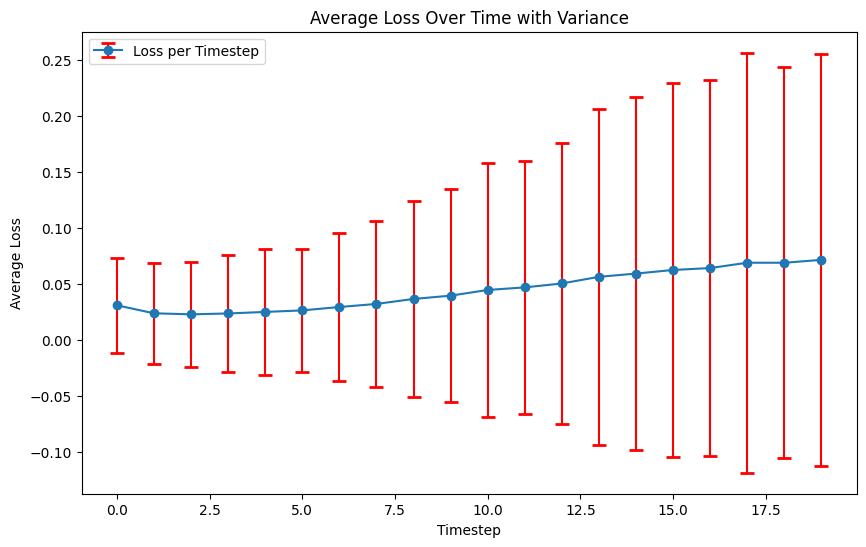

In [13]:
def process_losses(loss_t_series):
    # Initialize list of lists for each timestep
    loss_t = [[] for _ in range(config['T_diffusion'])]

    # Process each loss record and append to corresponding timestep
    for loss, t in loss_t_series:
        # Ensure tensor is on CPU and convert to Python scalar
        loss = loss.item() if isinstance(loss, torch.Tensor) else loss
        t = t.item() if isinstance(t, torch.Tensor) else t
        loss_t[t].append(loss)

    return loss_t

def display_losses(loss_t):
    # Calculate the average and variance of losses at each timestep
    average_losses = [np.mean(timestep_losses) if timestep_losses else 0 for timestep_losses in loss_t]
    variance_losses = [np.var(timestep_losses) if timestep_losses else 0 for timestep_losses in loss_t]
    std_dev_losses = np.sqrt(variance_losses)  # Standard deviation is the square root of variance
    
    # Now plot the processed losses with error bars representing the standard deviation
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(average_losses)), average_losses, yerr=std_dev_losses, label='Loss per Timestep', fmt='-o', ecolor='red', capthick=2, capsize=5)
    plt.title('Average Loss Over Time with Variance')
    plt.xlabel('Timestep')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()

base_t_losses = loss_history['base_t_losses']

base_t_losses_processed = process_losses(base_t_losses)
display_losses(base_t_losses_processed)

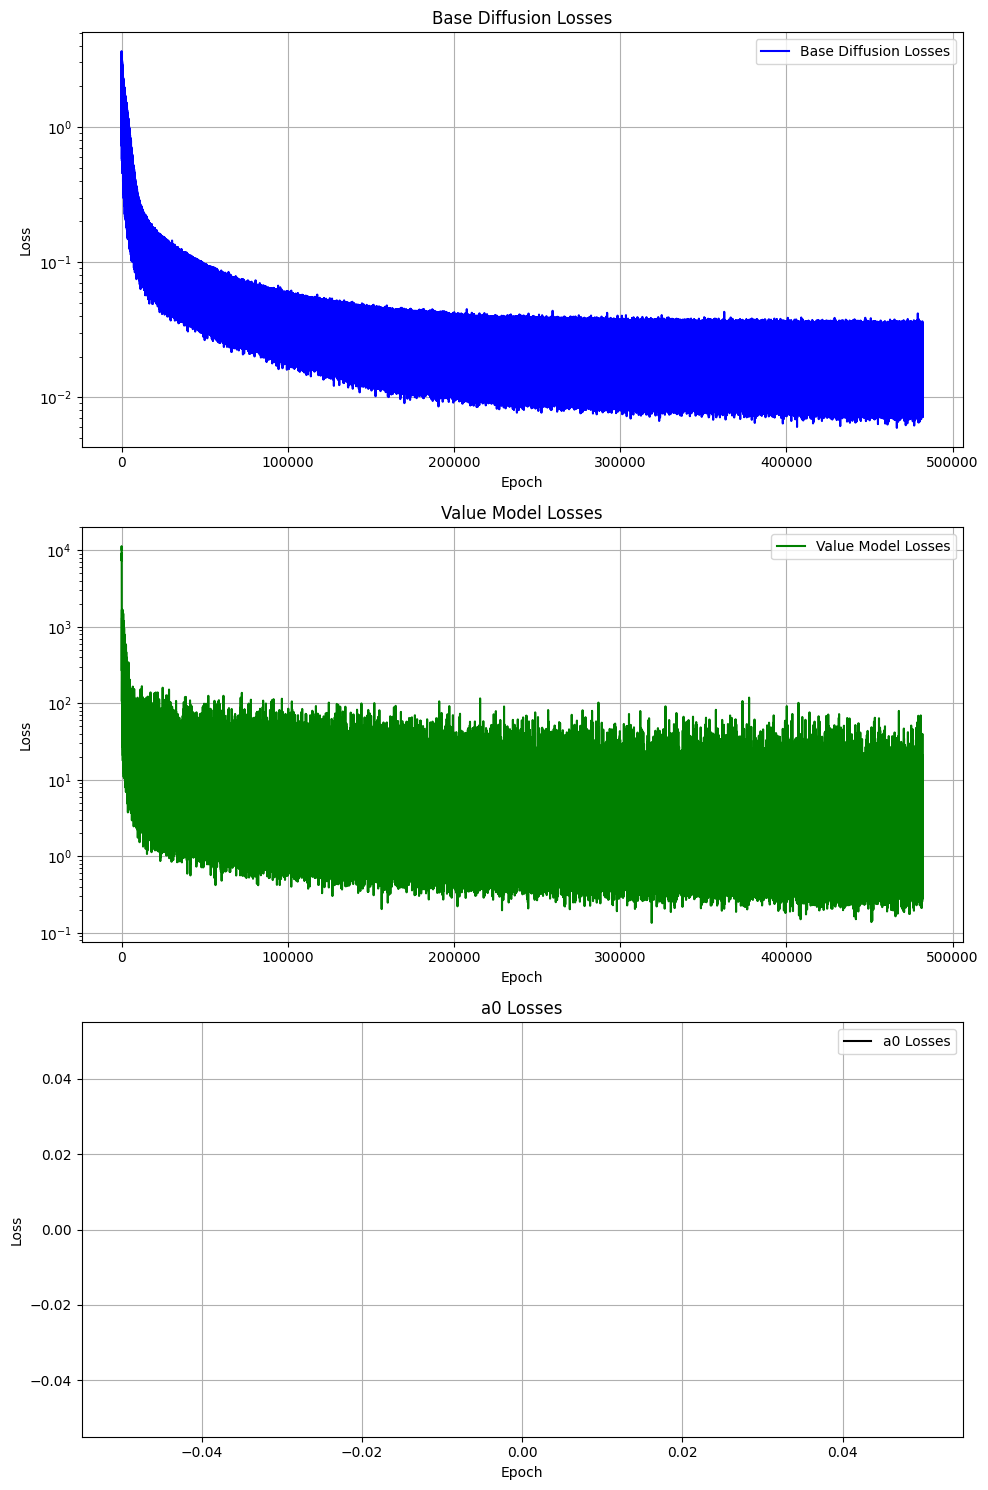

In [14]:
import matplotlib.pyplot as plt

# Extract and convert losses to CPU for plotting
base_losses_cpu = [loss for loss in loss_history['base_losses']]
value_losses_cpu = [loss for loss in loss_history['value_losses']]
a0_losses_cpu = [loss for loss in loss_history['a0_losses']]

# Plot the losses
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot base diffusion losses
axs[0].plot(base_losses_cpu, label='Base Diffusion Losses', color='b')
axs[0].set_title('Base Diffusion Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log')

# Plot value model losses
axs[1].plot(value_losses_cpu, label='Value Model Losses', color='g')
axs[1].set_title('Value Model Losses')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale('log')

# Plot value model losses
axs[2].plot(a0_losses_cpu, label='a0 Losses', color='k')
axs[2].set_title('a0 Losses')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)
#axs[2].set_yscale('log')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


initial alpha_bar_t s: tensor(0.9920) tensor(0.9721)
Final alpha_bar_t: tensor(6.0596e-06)
20


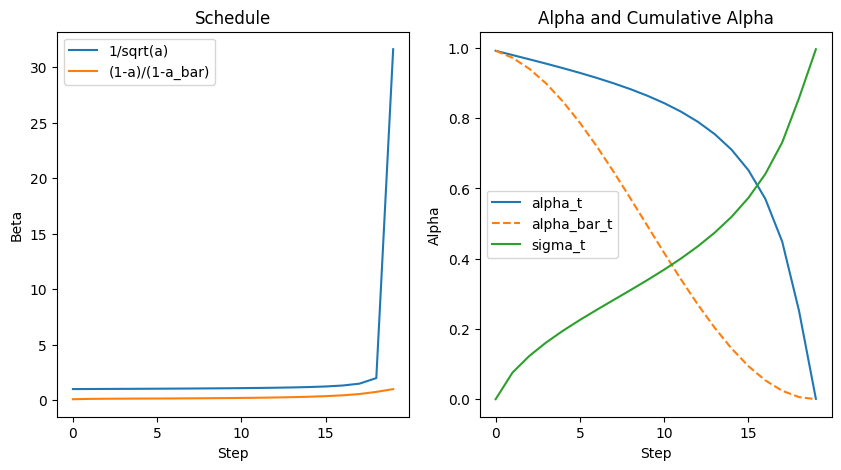

In [37]:
beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_schedule, 20, False, 0.00)
print("initial alpha_bar_t s:", alpha_bar_t[0], alpha_bar_t[1])
print("Final alpha_bar_t:", alpha_bar_t[-1])
print(len(beta_t))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(1/torch.sqrt(alpha_t), label='1/sqrt(a)')
plt.plot((1-alpha_t)/torch.sqrt(1-alpha_bar_t), label='(1-a)/(1-a_bar)')
plt.title('Schedule')
plt.xlabel('Step')
plt.ylabel('Beta')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alpha_t, label='alpha_t')
plt.plot(alpha_bar_t, label='alpha_bar_t', linestyle='--')
plt.plot(sigma_t, label='sigma_t')
plt.title('Alpha and Cumulative Alpha')
plt.xlabel('Step')
plt.ylabel('Alpha')
plt.legend()
plt.show()

**Testing**

In [ ]:
with open('walker2d-medium-v2.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)
    
# Example Configuration
latent_dim = 23
cond_dim = 0
config = {
    'horizon': 32,  # Sequence length
    'T_diffusion': 20,
    'transition_dim': latent_dim,
    'cond_dim': cond_dim,  
    'dim': 32,  # Hidden dimension
    'dim_mults': (1, 2, 4, 8),
    'state_dim': 17,
    'action_dim': 6,
    'attention': False,
    'batch_size': 1,
    'learning_rate': 4e-5,
    'base_num_epoch': 50,
    'value_num_epoch': 50
}

# load model and do testing
def load_model(config, save_path='model_checkpoints'):
    value_model = ValueModel(latent_dim)
    diffusion_model = DiffusionModel(latent_dim, hidden_dim)
    guided_diffusion_model = DiffusionModel(latent_dim, hidden_dim)
    
    models = {
        'value_model': value_model,
        'diffusion_model': diffusion_model
    }
    
    # Convert config values to string and construct the save path
    save_path = os.path.join(save_path, f"window_{str(config['horizon'])}_Tdiff_{str(config['T_diffusion'])}")

    # Load models
    for model_name, model in models.items():
        model_load_path = os.path.join(save_path, f"{model_name}.pt")
        model.load_state_dict(torch.load(model_load_path))
        print(f"Model {model_name} loaded from {model_load_path}")

    return models
        
models = load_model(config)    

torch.Size([1, 17])
tau_0_u.shape torch.Size([32, 23])


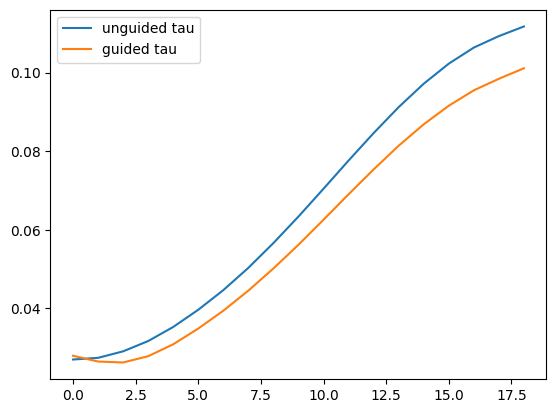

unguided trajectory:
 tensor([[-7.9276e-01,  5.3111e-01,  2.1089e-01, -1.0095e+00,  3.1762e-01,
         -9.4452e-02, -1.4150e+00, -1.0375e-01, -2.4517e-01, -1.1402e+00,
          9.7785e-01,  1.6670e-01,  2.0288e+00,  2.7257e+00, -6.7982e-01,
          1.1697e+00,  6.6900e-01, -1.0971e+00, -1.9898e+00, -8.5680e-01,
          7.1868e-01, -4.9031e-02, -6.9614e-01],
        [-5.1523e-01, -5.9189e-02,  1.7940e-01, -8.4741e-01,  8.0861e-01,
          2.0851e-01, -7.5952e-01, -1.0077e-01, -3.4645e-01, -7.1606e-01,
          1.0561e+00,  8.6870e-01, -1.0076e+00, -7.8182e-02,  1.5363e-01,
          2.8475e-01,  4.9211e-01, -1.5735e+00,  1.0816e+00, -7.3688e-01,
          9.2960e-01,  1.5728e+00, -8.7719e-02],
        [-5.2333e-01, -8.8342e-02,  4.8796e-02, -7.7727e-01,  1.4057e-01,
          2.2327e-01, -7.9888e-01, -1.9654e-01,  1.7425e-01, -9.1629e-01,
          1.8344e+00, -1.1811e+00,  1.7450e+00, -6.7117e-01, -1.1053e+00,
          1.5330e+00,  1.8823e+00,  3.2497e-01, -1.5461e+00, -6.02

In [23]:
random.seed(42)

device = 'cpu'

T_d = config['T_diffusion']
beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_schedule, T_d, False, 0)

value_model = models['value_model'].to('cpu')
diffusion_model = models['diffusion_model'].to('cpu')

trajectory_dataset = TrajectoryDataset(raw_dataset, config['horizon'])
mean = trajectory_dataset.mean
std = trajectory_dataset.std

def PlanningTrajectory(s,config):    
    T_d = config['T_diffusion']
    tau_t  = torch.randn(1, config['horizon'], config['transition_dim'])
    tau_t[0, 0, :-config['action_dim']] = s

    tau_unguided = []
    tau_guided = []
    tau_t_u = tau_t

    for t in reversed(range(1,T_d)):
        tau_t_u = diffusion_model(tau_t_u, 0,  torch.tensor([t]))
        tau_t_u[0, 0, :-config['action_dim']] = s
        tau_unguided.append(tau_t_u.mean().item())

        # Gradient-Based Guidance
        tau_t.requires_grad_(True)
        # Predict tau_{t-1} using the diffusion model
        tau_t = diffusion_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
    
        # Compute the gradient of the value model with respect to tau_t
        value = value_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
        #print(value.shape)
        value_grad = torch.autograd.grad(value.mean(), tau_t)[0]
    
        # Adjust the sample using the value gradient
        guidance_scale = 0.1  # Hyperparameter to control guidance strength
        tau_t = tau_t + guidance_scale * value_grad
        tau_t[0, 0, :-config['action_dim']] = s
    
        # Move to the next time step
        tau_t = tau_t.detach()

        tau_guided.append(tau_t.mean().item())

    # Use the denormalize method by passing the trajectory
    #tau_t_u = trajectory_dataset.denormalize(tau_t_u.detach().numpy())
    #tau_t = trajectory_dataset.denormalize(tau_t.detach().numpy())

    #tau_t_u = torch.from_numpy(tau_t_u).float() 
    #tau_t = torch.from_numpy(tau_t).float() 

    return tau_t_u, tau_t, tau_unguided, tau_guided
    
s = torch.randn((1,config['state_dim']))
print(s.shape)
tau_0_u, tau_0, tau_unguided, tau_guided = PlanningTrajectory(s,config)
tau_0_u = tau_0_u.squeeze(0)
tau_0 = tau_0.squeeze(0)
print("tau_0_u.shape", tau_0_u.shape)
t_0 = 0
plt.plot(tau_unguided[t_0:], label='unguided tau')
plt.plot(tau_guided[t_0:], label='guided tau')
plt.legend()
plt.show()
print("unguided trajectory:\n", tau_0_u)
#print("guided trajectory:\n", tau_0)

In [30]:
def displayInfo(tau, config):
    # Extract action and state based on config['action_dim']
    action = tau[0, :, -config['action_dim']:]
    action = torch.clamp(action, min=-1, max=1)
    state = tau[0, :, :-config['action_dim']]

    fig, (subplot1, subplot2) = plt.subplots(1, 2, figsize=(12, 6))
    
    for i in range (config['action_dim']-5):
        x_i = action[:, i]
        series = [x.mean().item() for x in x_i]
        subplot1.plot(series, 'black')
    
    for i in range (config['state_dim']):
        x_i = state[:, i]
        series = [x.mean().item() for x in x_i]
        subplot2.plot(series, 'red')

torch.Size([1, 32, 23])
torch.Size([17])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
true value: tensor([20.3328])
tensor([[19.6366]], grad_fn=<AddmmBackward0>) tensor([[29.9869]], grad_fn=<AddmmBackward0>) tensor([[42.8203]], grad_fn=<AddmmBackward0>)


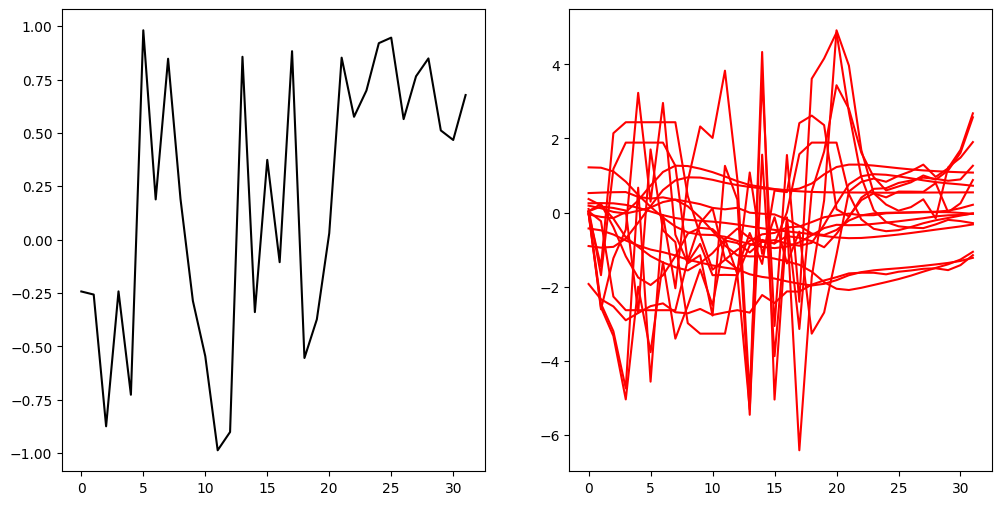

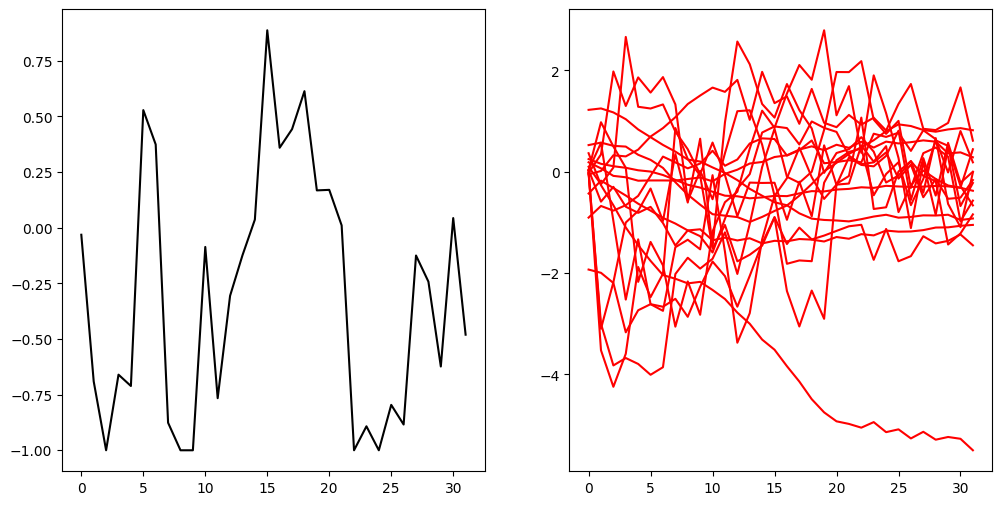

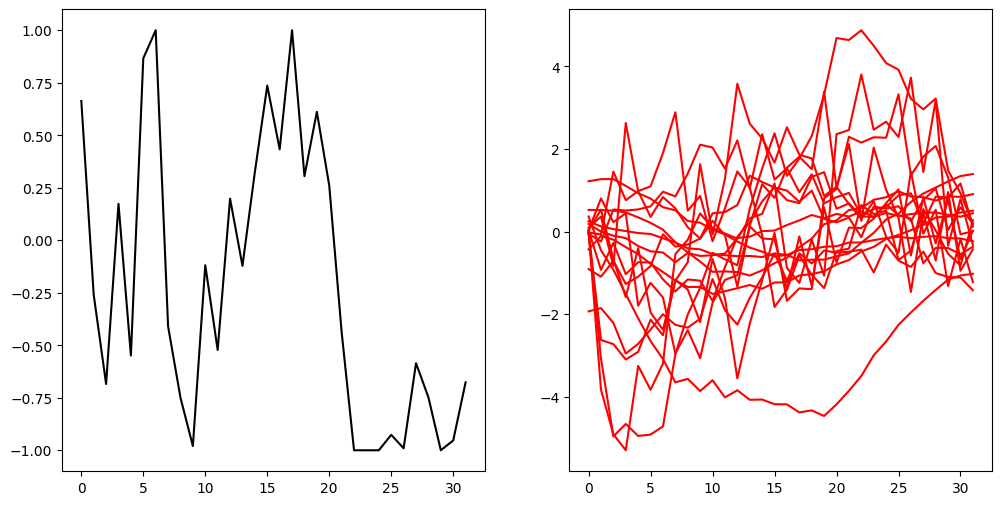

0
torch.Size([1, 32, 23])
torch.Size([17])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
true value: tensor([39.3364])
tensor([[39.1184]], grad_fn=<AddmmBackward0>) tensor([[29.8179]], grad_fn=<AddmmBackward0>) tensor([[41.1821]], grad_fn=<AddmmBackward0>)


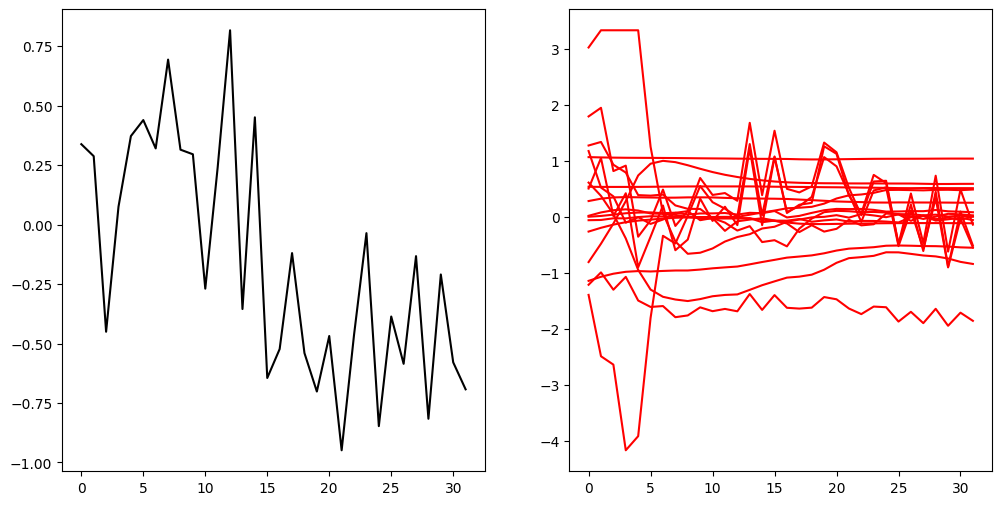

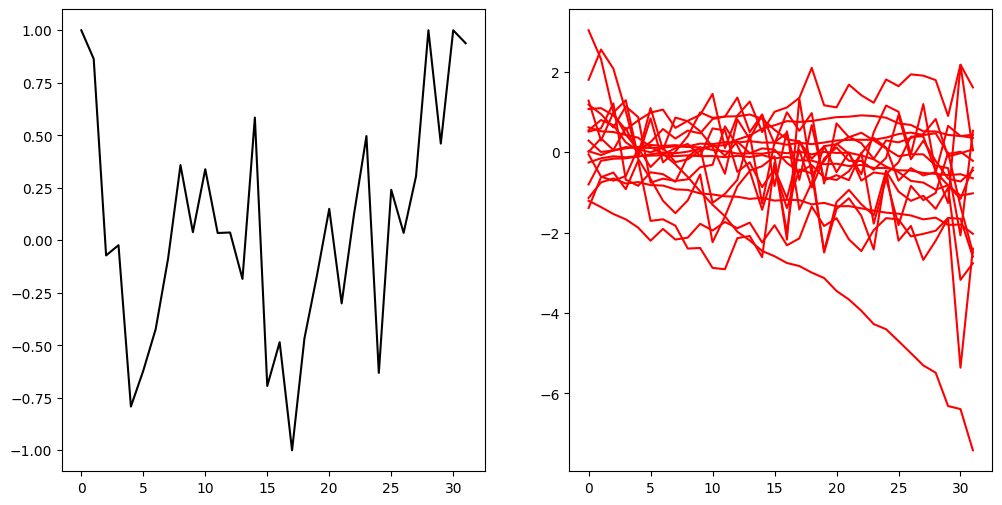

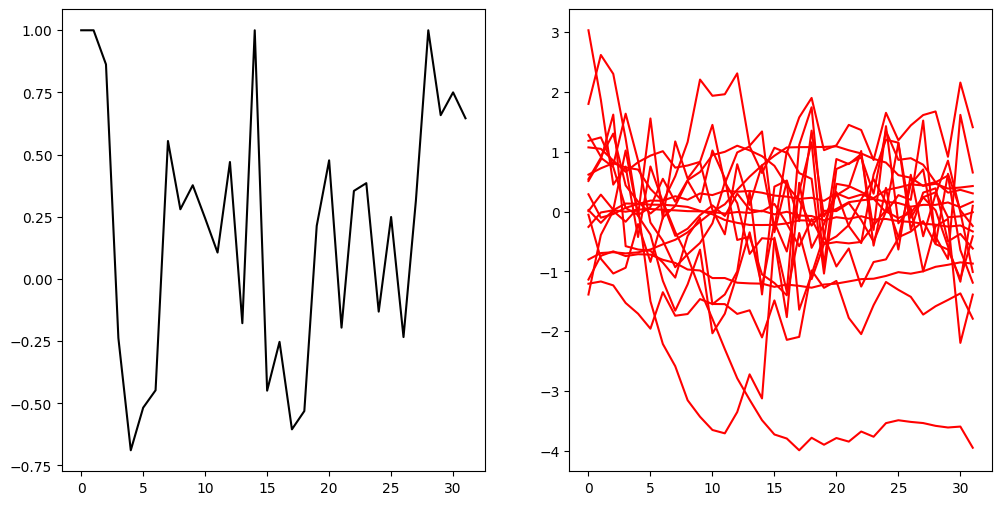

1
torch.Size([1, 32, 23])
torch.Size([17])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
true value: tensor([33.5318])
tensor([[32.1176]], grad_fn=<AddmmBackward0>) tensor([[26.9171]], grad_fn=<AddmmBackward0>) tensor([[30.8713]], grad_fn=<AddmmBackward0>)


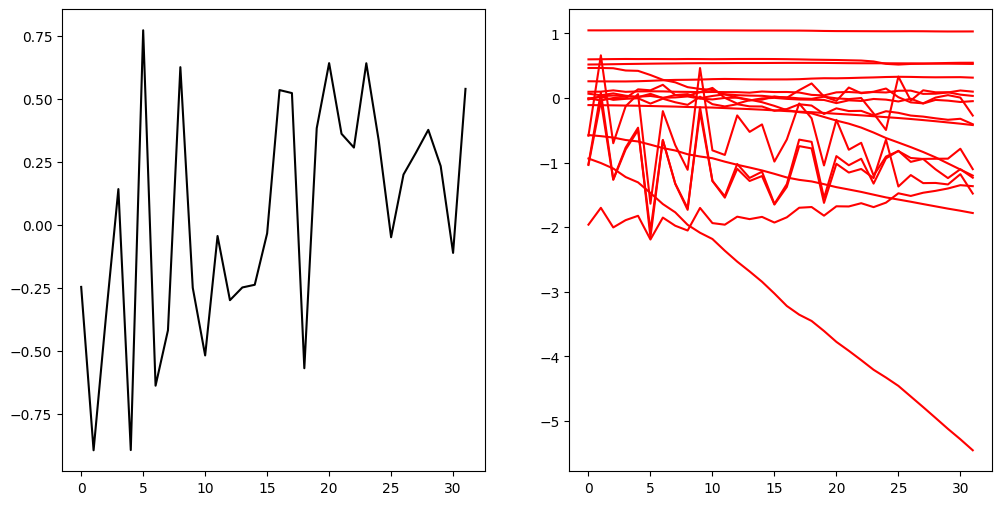

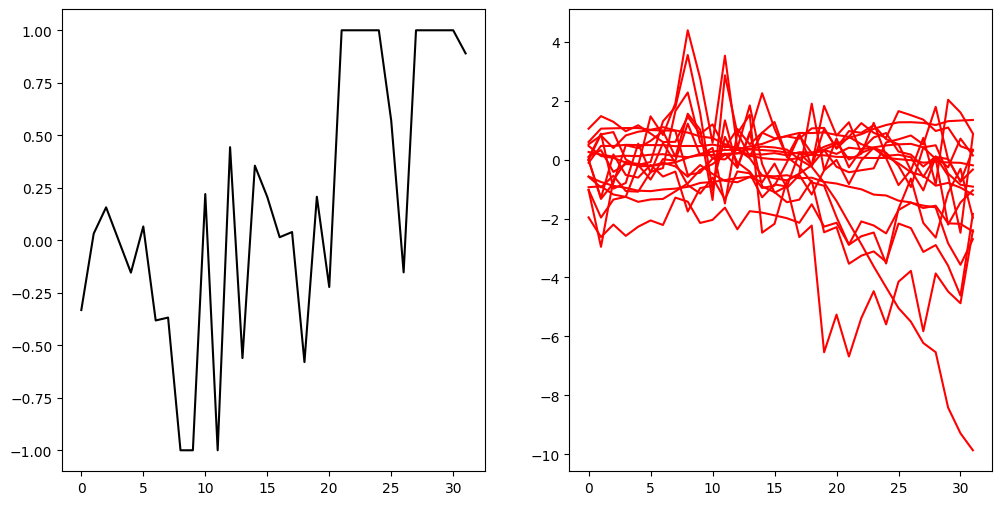

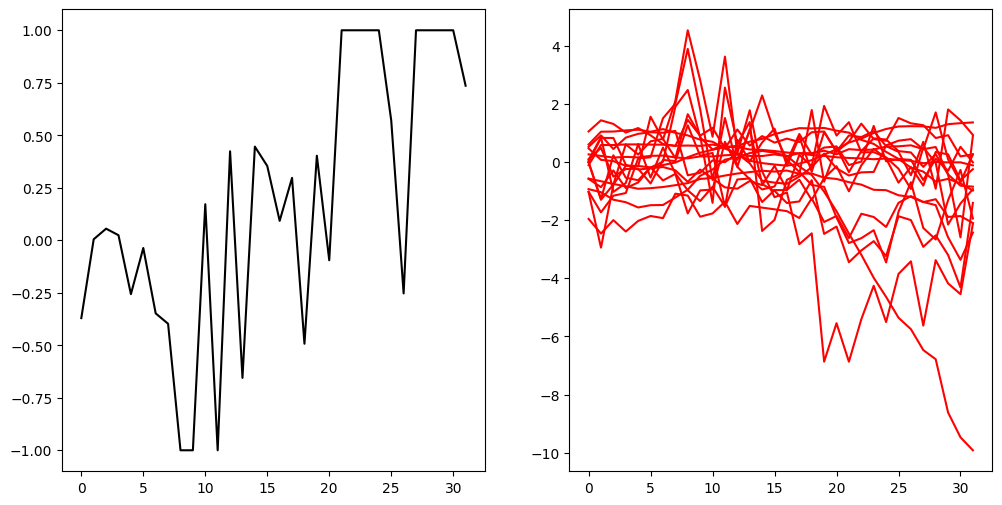

2
torch.Size([1, 32, 23])
torch.Size([17])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
true value: tensor([85.3636])
tensor([[84.5539]], grad_fn=<AddmmBackward0>) tensor([[61.9859]], grad_fn=<AddmmBackward0>) tensor([[68.2513]], grad_fn=<AddmmBackward0>)


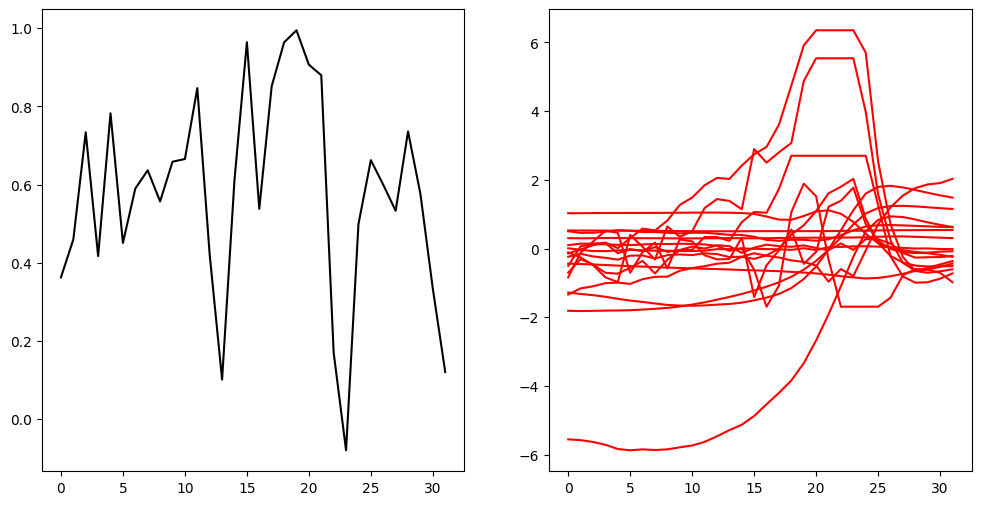

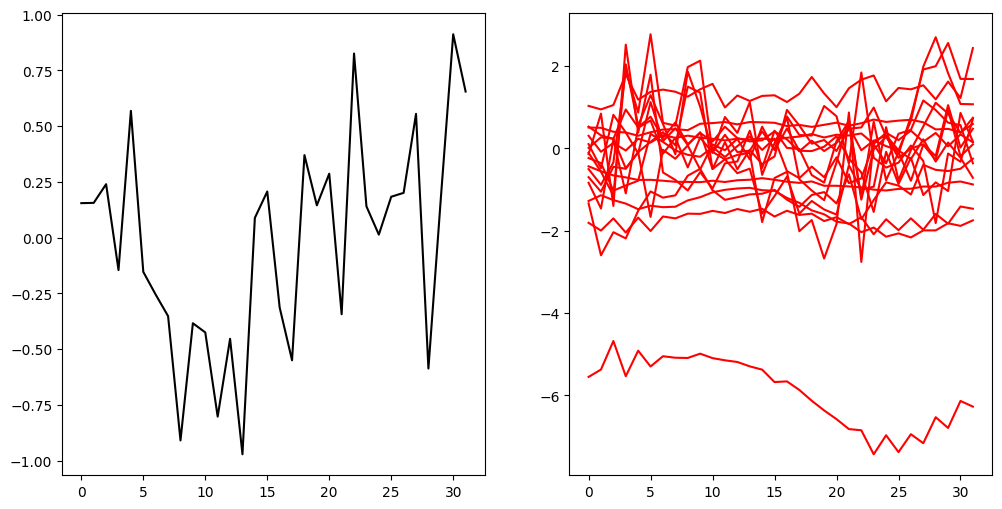

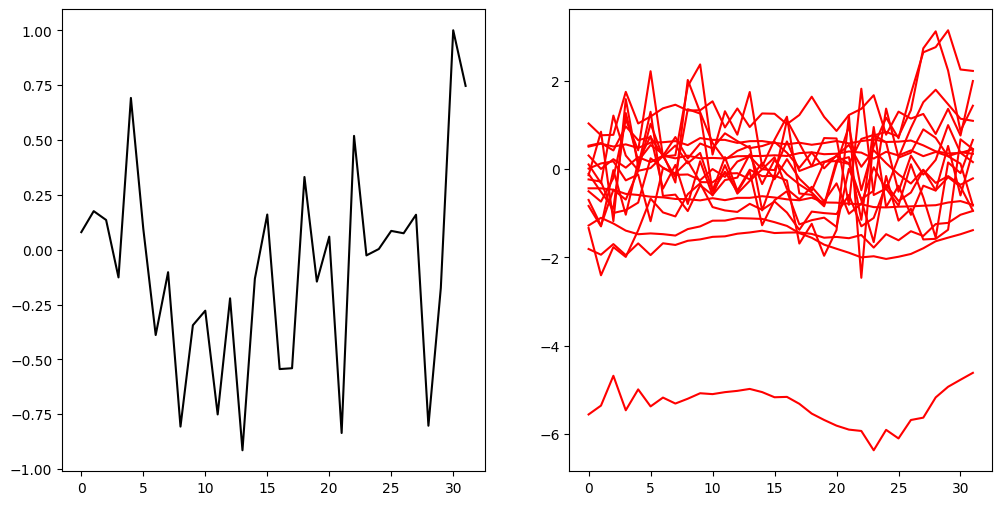

3
torch.Size([1, 32, 23])
torch.Size([17])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
true value: tensor([77.1160])
tensor([[77.1323]], grad_fn=<AddmmBackward0>) tensor([[76.4343]], grad_fn=<AddmmBackward0>) tensor([[79.8584]], grad_fn=<AddmmBackward0>)


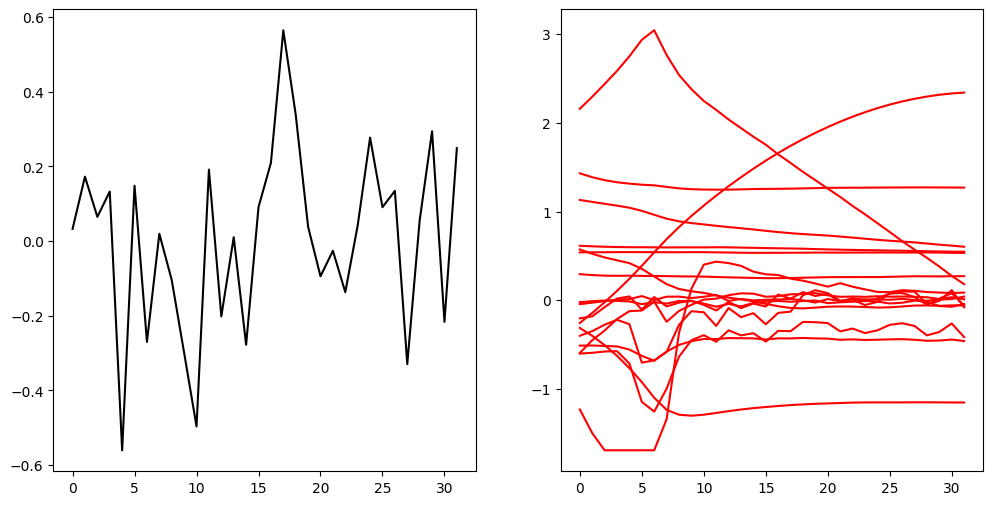

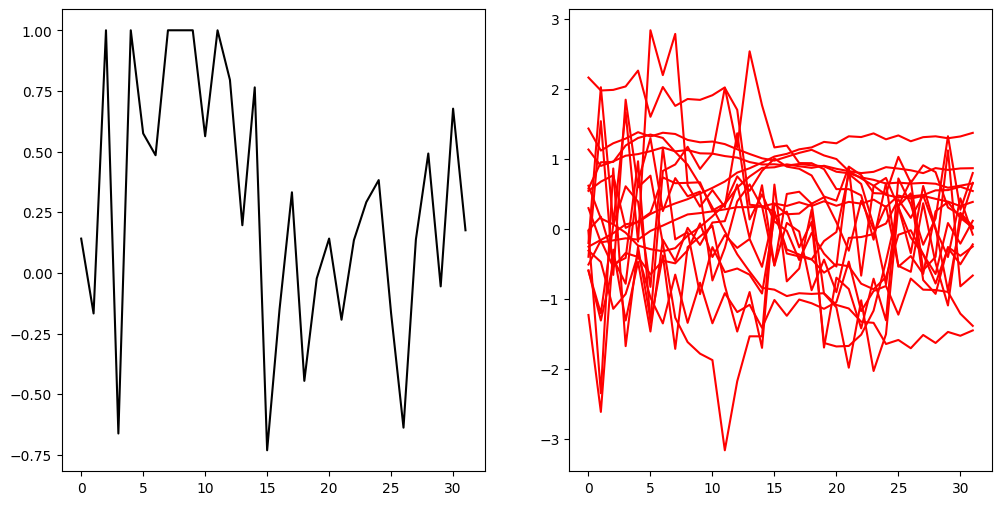

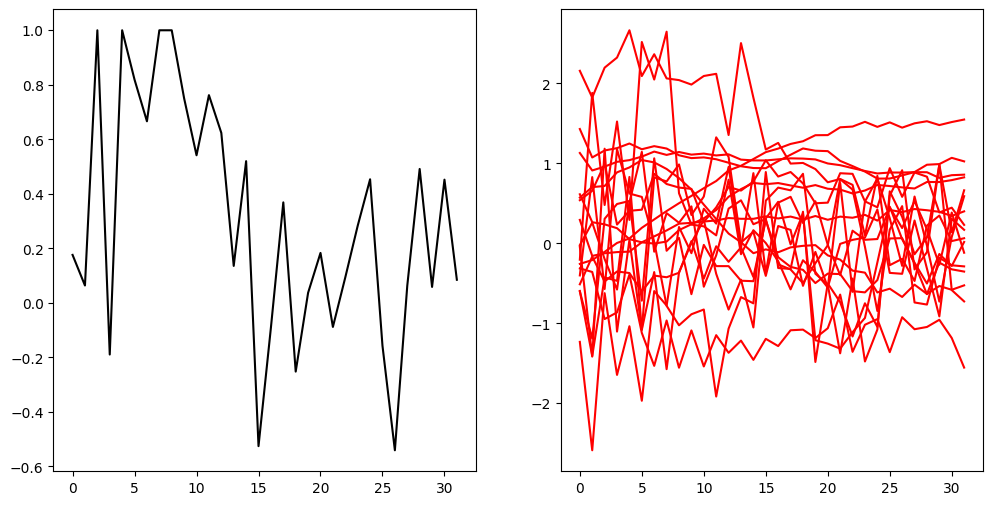

4
torch.Size([1, 32, 23])
torch.Size([17])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
torch.Size([1, 32, 23]) torch.Size([1, 32, 23])
true value: tensor([77.6410])
tensor([[77.8361]], grad_fn=<AddmmBackward0>) tensor([[70.1918]], grad_fn=<AddmmBackward0>) tensor([[74.5126]], grad_fn=<AddmmBackward0>)


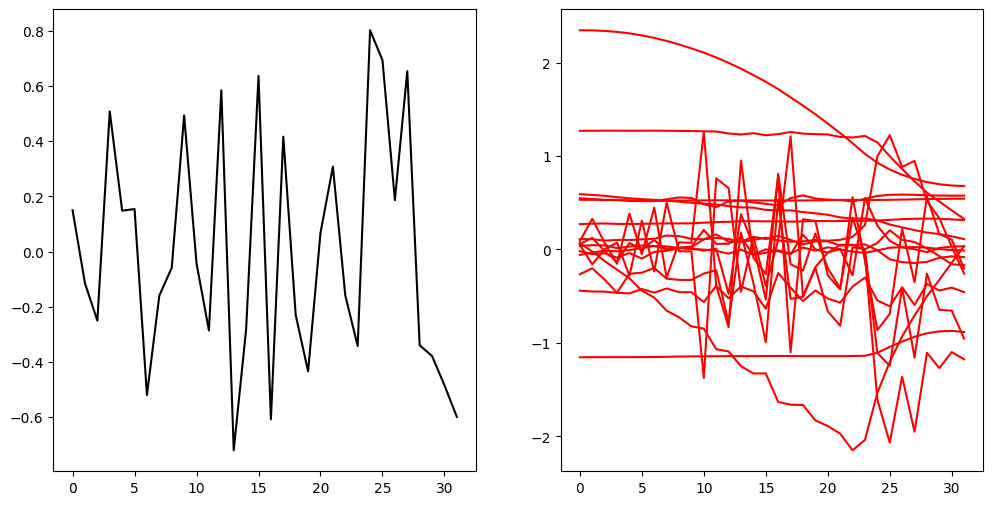

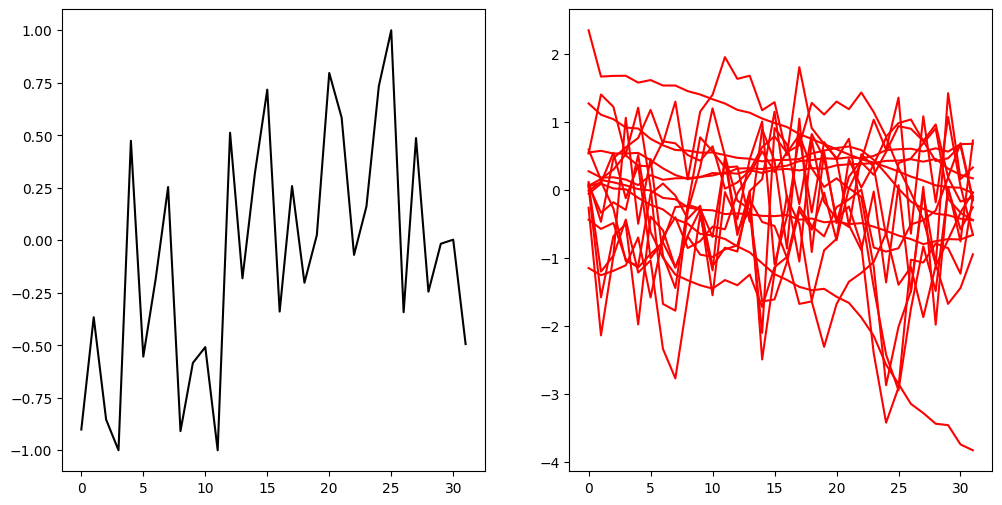

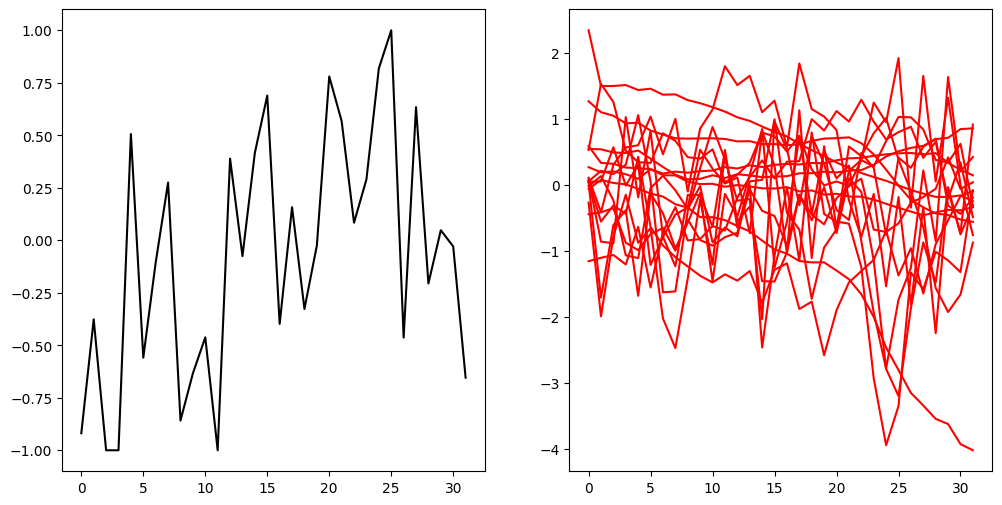

5


In [31]:
# torch.tensor([t], dtype=torch.float32, device=device)
random.seed(42)
dataloader = DataLoader(TrajectoryDataset(raw_dataset, config['horizon']), config['batch_size'], shuffle=False, collate_fn=collate_fn)

i = 0
for iteration, (tau_0, value) in enumerate(dataloader):
    print(tau_0.shape)
    v_0 = value_model(tau_0, 0, torch.tensor([0], dtype=torch.float32, device='cpu'))
    mean = trajectory_dataset.mean
    std = trajectory_dataset.std
    #tau_0 = tau_0 * std + mean
    displayInfo(tau_0, config)

    s = tau_0[0, 0,:-config['action_dim']]
    print(s.shape)
    tau_0_u, tau_0, tau_unguided, tau_guided = PlanningTrajectory(s,config)
    
    print(tau_0_u.shape, tau_0.shape)
    
    displayInfo(tau_0_u, config)
    displayInfo(tau_0, config)
    print(tau_0.shape, tau_0_u.shape)
    v_1 = value_model(tau_0_u, 0, torch.tensor([0], dtype=torch.float32, device='cpu'))
    v_2 = value_model(tau_0, 0, torch.tensor([0], dtype=torch.float32, device='cpu'))
    print('true value:', value)
    print(v_0, v_1, v_2)

    plt.show()
    print(i)
    i+=1
    if i > 5:
        break

In [29]:

# Function to test the model
def test_model(models, config, env_name='Walker2d-v4', num_episodes=5):
    # Create the environment
    env = gym.make(env_name, render_mode='human')

    diff = []
    # Loop through episodes for testing
    for episode in range(num_episodes):
        observation, info = env.reset()
        done = False
        value = 0

        terminated, truncated = False, False
        i = 0
        while not (terminated or truncated):
        #for _ in range (30):
            if i == 0 or i == config['horizon']:
                if i == config['horizon']:
                    print("true value:\n", value)
                    t_0 = torch.tensor([0], dtype=torch.float32, device='cpu')
                    tau_true_tensor = torch.tensor(tau_true, dtype=torch.float32).unsqueeze(0)
                    print("pred value:\n", value_model(tau_true_tensor, 0, t_0))

                tau_true = []
                obs = torch.tensor(observation)
                mean = trajectory_dataset.mean
                std = trajectory_dataset.std
                obs = (obs - mean[:-config['action_dim']])/(std[:-config['action_dim']]+ 1e-8)
                #obs = obs.unsqueeze(0)
                tau_0_u, tau_0, tau_unguided, tau_guided = PlanningTrajectory(obs, config)
                i = 0

            #print(i, tau_0.shape)
            action_pred = tau_0_u[0, i, -config['action_dim']:]
            #action_pred = tau_0[0, i, -config['action_dim']:]
            action_pred = torch.clamp(action_pred, min=-1, max=1)
            action_pred = action_pred.detach().numpy()
            i += 1
            
            action = env.action_space.sample()
            #print(action, action_pred)
            #print(observation, state_pred)

            action_taken = action_pred
            
            # Step the environment with the action
            #observation, reward, terminated, truncated, info = env.step(action)
            observation, reward, terminated, truncated, info = env.step(action_taken)
            value += reward

    env.close()

test_model(models, config, env_name='Walker2d-v4', num_episodes=5)

true value:
 31.992923488748744
pred value:
 tensor([[98.6005]], grad_fn=<AddmmBackward0>)
true value:
 60.87676386819399
pred value:
 tensor([[103.6166]], grad_fn=<AddmmBackward0>)
true value:
 106.28382257613563
pred value:
 tensor([[111.6024]], grad_fn=<AddmmBackward0>)
true value:
 20.9552070359018
pred value:
 tensor([[78.4085]], grad_fn=<AddmmBackward0>)
true value:
 74.13213900826199
pred value:
 tensor([[105.2073]], grad_fn=<AddmmBackward0>)
true value:
 152.42854492204418
pred value:
 tensor([[110.0503]], grad_fn=<AddmmBackward0>)
true value:
 243.74973348944388
pred value:
 tensor([[138.2568]], grad_fn=<AddmmBackward0>)
true value:
 8.057606755092294
pred value:
 tensor([[85.6769]], grad_fn=<AddmmBackward0>)
true value:
 19.407405100473333
pred value:
 tensor([[85.6765]], grad_fn=<AddmmBackward0>)
true value:
 74.1989996415641
pred value:
 tensor([[103.7047]], grad_fn=<AddmmBackward0>)
true value:
 38.95253980616845
pred value:
 tensor([[95.4203]], grad_fn=<AddmmBackward0>)
t